In [31]:
!pip3 install pywaffle

You should consider upgrading via the 'C:\Users\Carlo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [33]:
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import numpy as np
import statistics
from collections import Counter

ModuleNotFoundError: No module named 'pywaffle'

In [6]:
#Loading Data
f = open("db_dump_new_files.json").read()

#remove image0/image1 vars since it prevents proper df merging
g = re.sub(r'_image[0-2]',"",f)

data = json.loads(g)
df = pd.json_normalize(data)

#hacky solution to remove the panda-appended user_. entry
renamed= [name.split("_.")[-1] for name in df.columns]
col_rename = {i:j for i,j in zip(df.columns,renamed)}
df = df.rename(columns=col_rename)

In [7]:
def createSubDFs(df):
    profiling_df = df[['user_profiling_age', 'user_profiling_position',
        'user_profiling_useOfDP', 'user_profiling_useOfAI',
        'user_profiling_useOfAI_details', 'user_profiling_mlFamiliarity']]

    cf_df = df[[ 'counterfactuals_twoAxisCounterfactuals_understandability',
        'counterfactuals_twoAxisCounterfactuals_usability',
        'counterfactuals_twoAxisCounterfactuals_informativeness',
        'counterfactuals_twoAxisCounterfactuals_value',
        'counterfactuals_prototypeInterpolation_understandability',
        'counterfactuals_prototypeInterpolation_usability',
        'counterfactuals_prototypeInterpolation_informativeness',
        'counterfactuals_prototypeInterpolation_value']]

    ca_df = df[['conceptAttribution_textAttributes_understandability',
        'conceptAttribution_textAttributes_usability',
        'conceptAttribution_textAttributes_informativeness',
        'conceptAttribution_textAttributes_value',
        'conceptAttribution_textAttributes_comments']]

    prototypes_df = df[['prototypes_prototypes_understandability',
        'prototypes_prototypes_usability',
        'prototypes_prototypes_informativeness',
        'prototypes_prototypes_value']]

    trust_df = df[['trustScores_borderlineCases_understandability',
        'trustScores_borderlineCases_usability',
        'trustScores_borderlineCases_value',
        'trustScores_borderlineCases_informativeness',
        'trustScores_borderlineCases_comments']]

    return profiling_df,cf_df,ca_df,prototypes_df,trust_df

In [8]:
#remove NaN columns, careful since missing comments are read as NaN which can lead to very empty dfs
#df = df.dropna()

#get column values while dropping individual NaNs for debugging purposes
# test_data = df["user_profiling_useOfDP"]
# test_data = test_data.dropna().unique().tolist()

#select subdfs grouped by column for easier handling
profiling_df,cf_df,ca_df,prototypes_df,trust_df = createSubDFs(df)


[1, 1, 0, 1]


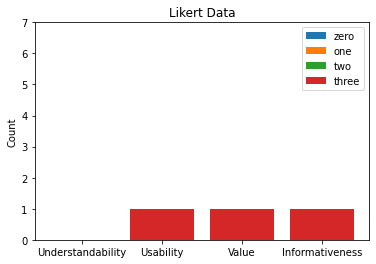

[[4 4 3 3]
 [6 3 6 4]
 [5 5 6 6]]
count               3
unique              3
top       in research
freq                1
Name: user_profiling_useOfDP, dtype: object


<Figure size 432x288 with 0 Axes>

In [66]:

#function to plot a column
def boxPlot(data,title):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.boxplot(data)

#boxPlot(prototypes_df.iloc[0],"TestTitle")
labels = ["Understandability","Usability","Value","Informativeness"]

#and the full subdf
def boxPlotDF(sub_df,title,labels):
    #throw out non-numeric data
    int_df = sub_df.select_dtypes(include="int64")
    data = int_df.values
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_ylabel("Agreement")
    ax.set_ylim(0,7)
    ax.boxplot(data)

def stackedBarChartDF(sub_df,title,labels):
    #throw out non-numeric data
    int_df = sub_df.select_dtypes(include="int64")
    data = int_df.values
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.set_ylim(0,7)

    #get the occurences in the respective column
    understandability = Counter(data[:,0])
    usability = Counter(data[:,1])
    value = Counter(data[:,2])
    informativeness = Counter(data[:,3])

    zeros = [understandability[0],usability[0],value[0],informativeness[0]]
    ones = [understandability[1],usability[1],value[1],informativeness[1]]
    twos = [understandability[2],usability[2],value[2],informativeness[2]]
    threes = [understandability[3],usability[3],value[3],informativeness[3]]
    fours = [understandability[4],usability[4],value[4],informativeness[4]]
    fives = [understandability[5],usability[5],value[5],informativeness[5]]
    sixes = [understandability[6],usability[6],value[6],informativeness[6]]
    sevens = [understandability[7],usability[7],value[7],informativeness[7]]

    ax.bar(labels,zeros,label="zero")
    ax.bar(labels,ones, label="one")
    ax.bar(labels,twos, label="two")
    ax.bar(labels,threes, label="three")
    ax.bar(labels,fours, label="four")
    ax.bar(labels,fives, label="fives")
    ax.bar(labels,sixes, label="sixes")
    ax.bar(labels,sevens, label="sevens")
    ax.legend(loc="best")
    

#boxPlotDF(trust_df,"Trust Based Methods")
stackedBarChartDF(trust_df,"Likert Data",labels)
plt.savefig("StackedBarChart")

#function to get most relevant statistical measures for single column
def descriptiveStatistics(column):
    print(df[column].describe())

descriptiveStatistics("user_profiling_useOfDP")


In [73]:
#compare all approaches 

#1. step: create average,var score of each rating question per subdf
df_list = [cf_df,ca_df,prototypes_df,trust_df]
def applyFunctionToSubDF(df_list,func):
    avg_container = []
    #for each df, get an average of the ratings for understand,usab,value and info (or any other function you want to apply to the seletced subdf)
    for sub_df in df_list:
        understand_avg = round(func(sub_df.filter(regex=(".*_understandability")).values),2)
        usability_avg = round(func(sub_df.filter(regex=(".*_usability")).values),2)
        value_avg = round(func(sub_df.filter(regex=(".*_value")).values),2)
        info_avg = round(func(sub_df.filter(regex=(".*_informativeness")).values),2)

        sub_df_avg = [info_avg,understand_avg,usability_avg,value_avg]
        avg_container.append(sub_df_avg)

    #make sure that the input ordering in the df_list is the same as in the method call since I only rely on ordering, not on names
    return avg_container[0],avg_container[1],avg_container[2],avg_container[3]

cf_avg,ca_avg,prototypes_avg,trust_avg = applyFunctionToSubDF(df_list,np.mean)
cf_var,ca_var,prototypes_var,trust_var = applyFunctionToSubDF(df_list,np.var)

#2. step: compare them in a table with avg+sdv
comparison_df = pd.DataFrame(index=["Understandability","Usability","Value","Informativeness"])
comparison_df["TrustScores"] = trust_avg
comparison_df["CounterFactuals"] = cf_avg
comparison_df["CA"] = ca_avg
comparison_df["Prototypes"] = prototypes_avg

print(comparison_df)


                   TrustScores  CounterFactuals    CA  Prototypes
Understandability         4.33             5.83  6.33        6.33
Usability                 5.00             6.00  6.00        6.33
Value                     4.00             5.50  6.00        6.33
Informativeness           5.00             6.00  6.67        6.67
